In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

In [2]:
# Ruta al dataset
DATASET_DIR = "/Users/damian/Universidad/redes_neuronales/reto/smiles"
# comprobar la ruta
print("DATASET_DIR existe?", os.path.exists(DATASET_DIR))

DATASET_DIR existe? True


In [ ]:
def cargar_y_dividir_dataset_estilo_companero(
    rootpath=DATASET_DIR,
    target_size=(64, 64),
    test_size=0.2,
    random_state=123,
    max_n=None   # si quieres limitar imágenes, tipo 2500
):
    smile_dir = os.path.join(rootpath, "smile")
    not_smile_dir = os.path.join(rootpath, "not_smile")

    # Listar archivos de cada carpeta
    files_smile = os.listdir(smile_dir)
    files_non_smile = os.listdir(not_smile_dir)

    # número máximo de imágenes por clase
    if max_n is None:
        n = min(len(files_smile), len(files_non_smile))
    else:
        n = min(max_n, len(files_smile), len(files_non_smile))

    print("Voy a usar n =", n, "por clase (smile / not_smile)")

    imgs_smiles = []
    imgs_non = []

    # Tomar los primeros n de cada clase
    for i in range(n):
        # SMILE
        path_smile = os.path.join(smile_dir, files_smile[i])
        img_s = image.load_img(path_smile, target_size=target_size)
        arr_s = image.img_to_array(img_s) / 255.0
        imgs_smiles.append(arr_s)

        # NOT_SMILE
        path_non = os.path.join(not_smile_dir, files_non_smile[i])
        img_n = image.load_img(path_non, target_size=target_size)
        arr_n = image.img_to_array(img_n) / 255.0
        imgs_non.append(arr_n)

    imgs_smiles = np.array(imgs_smiles)
    imgs_non   = np.array(imgs_non)

    # Concatenar X e y
    X = np.concatenate((imgs_smiles, imgs_non), axis=0)
    y = np.concatenate(
        (np.ones(len(imgs_smiles)),  # 1 = smile
         np.zeros(len(imgs_non)))   # 0 = no_smile
    )

    print("Total de imágenes cargadas:", X.shape[0])
    print("Dimensión de imagen:", X.shape[1:])

    # Mezclar antes del split
    np.random.seed(random_state)
    idxs = np.random.permutation(len(X))
    X = X[idxs]
    y = y[idxs]

    # train_test_split estratificado
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    # Aplanado para modelos clásicos (Random Forest, SVM, etc.)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat  = X_test.reshape(X_test.shape[0], -1)

    print("Tamaño X_train:", X_train.shape, "| X_train_flat:", X_train_flat.shape)
    print("Tamaño X_test: ", X_test.shape,  "| X_test_flat: ", X_test_flat.shape)

    return (
        X_train, X_test,
        y_train, y_test,
        X_train_flat, X_test_flat
    )

In [5]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
(
    X_train, X_test,
    y_train, y_test,
    X_train_flat, X_test_flat
) = cargar_y_dividir_dataset_estilo_companero(
    rootpath=DATASET_DIR,
    target_size=(64, 64),   # para RF está bien más chico
    test_size=0.2,
    random_state=123,
    max_n=None              # o por ejemplo 2500 si tuvieras más
)

print("Tamaño train:", X_train_flat.shape)
print("Tamaño test:", X_test_flat.shape)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=1234,
    n_jobs=-1
)

print("\nEntrenando Random Forest...")
rf.fit(X_train_flat, y_train)

print("\nEvaluación Random Forest:")
y_pred = rf.predict(X_test_flat)

print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=["no_smile", "smile"]
    )
)

Voy a usar n = 600 por clase (smile / not_smile)
Total de imágenes cargadas: 1200
Dimensión de imagen: (64, 64, 3)
Tamaño X_train: (960, 64, 64, 3) | X_train_flat: (960, 12288)
Tamaño X_test:  (240, 64, 64, 3) | X_test_flat:  (240, 12288)
Tamaño train: (960, 12288)
Tamaño test: (240, 12288)

Entrenando Random Forest...

Evaluación Random Forest:

Matriz de confusión:
[[110  10]
 [ 15 105]]

Reporte de clasificación:
              precision    recall  f1-score   support

    no_smile       0.88      0.92      0.90       120
       smile       0.91      0.88      0.89       120

    accuracy                           0.90       240
   macro avg       0.90      0.90      0.90       240
weighted avg       0.90      0.90      0.90       240



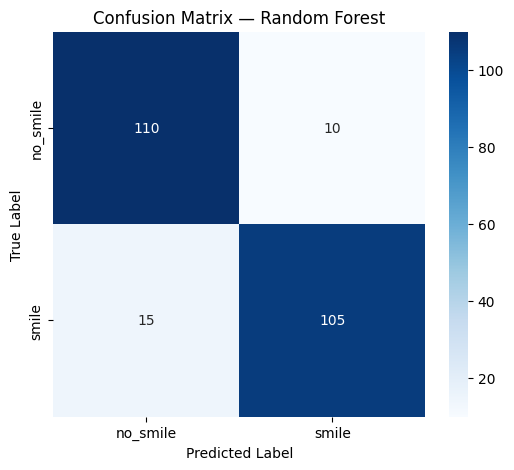

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["no_smile", "smile"],
            yticklabels=["no_smile", "smile"])
plt.title("Confusion Matrix — Random Forest")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

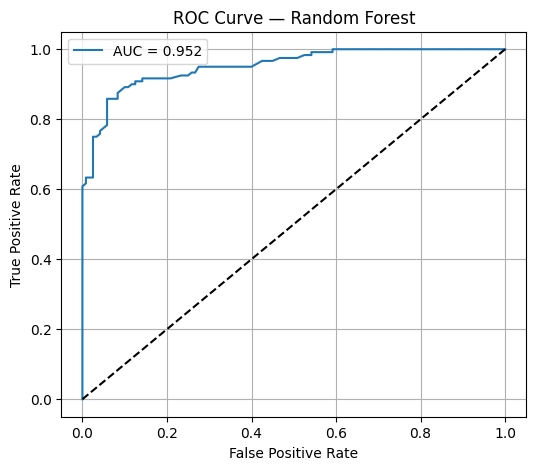

In [8]:
from sklearn.metrics import roc_curve, auc

y_prob = rf.predict_proba(X_test_flat)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve — Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()